# 1.Data processing
In this part data is ingested from JSON source files, it's appended to pandas dataframes and database is created as well, allowing further analysis.


In [1]:
##importing necessary libraries
#pandas for handling tabular data and matplotlib for visualization
import pandas as pd
import matplotlib.pyplot as plt
#datetime and time for working with time and dates
from datetime import datetime
import time
#json module from python standard library to handle source files in this format
import json
#os module to handle files in different directories
import os.path
#filedialog method from tkinter library to invoke file prompt, so it's not necessary to provide path to directory
import tkinter.filedialog
#sqlite for creating a database and connecting to it
import sqlite3
#pretty printing for displaying queries results
import pprint

%matplotlib inline

#getting current time to measure how long does it take for the script to run
start_time = time.time()

#archive directory
groups_directory = tkinter.filedialog.askdirectory(title = 'Please choose the directory of the unzipped archive')

#creating lists to store data from all JSON files. For each iteration, data is added to the lists
time_sent,sender,message, conversation, conversation_type = ([] for i in range(5))

processed_files_counter = 0
#loop to go through all files that contains messages and to append messages to lists
if os.path.isdir(os.path.join(groups_directory, "messages")):
    for subdir, dirs, files in os.walk(groups_directory + "/messages"):
        for file in files:
            if os.path.join(subdir, file).endswith("json"):
                with open(os.path.join(subdir, file)) as f:
                    data = json.loads(f.read())
                    if 'messages' in data:
                        for i in data['messages']:
                            try:
                                sender.append(i['sender_name'].encode('latin1').decode('utf8'))
                                time_sent.append(i['timestamp_ms'])
                                conversation.append(data['title'].encode('latin1').decode('utf8'))
                                conversation_type.append(data['thread_type'])
                                message.append(i['content'].encode('latin1').decode('utf8'))
                            except KeyError:
                                message.append("") 
                        processed_files_counter += 1
                            
#timestamp to date
converted_time_sent = [datetime.fromtimestamp(int(i)/1000.0).strftime('%Y-%m-%d %H:%M:%S') for i in time_sent]

#using all the lists to create a dataframe
df = pd.DataFrame(list(zip(conversation, conversation_type,sender, converted_time_sent, message)),
              columns=['Conversation','Conversation_type','Sender','Time', 'Message'])


#adding additional columns, which will be helpful in the analysis
df['Sent_received'] = df.apply(lambda x: 'sent' if x['Sender'] == 'Przemysław Kępka' else 'received',axis=1)
df['Time'] = pd.to_datetime(df['Time'])
df['Year'] = df['Time'].dt.year
df['Day'] = df['Time'].dt.strftime('%d-%m-%Y')
df['Day'] = pd.to_datetime(df['Day'],dayfirst=True)
df['Hour'] = df['Time'].dt.hour


#opening file with list of friends
with open(os.path.join(groups_directory, "friends_and_followers", 'friends.json')) as f:
    data_f = json.loads(f.read())

friends = []
date_added = []
for i in data_f['friends_v2']:
    friends.append(i['name'].encode('latin1').decode('utf8'))
    date_added.append(i['timestamp'])

date_added = [datetime.fromtimestamp(i).strftime('%Y-%m-%d') for i in date_added]

df_friends = pd.DataFrame(list(zip(friends,date_added)),
              columns=['Name','Date_added'])

#reversing the order to have the index starting from oldest friends
df_friends = df_friends.iloc[::-1].reset_index(drop=True)


### Creating a database

#Database is created if does not exist, tables are also created
db_name = 'Facebook_archive_' + datetime.now().strftime("%d-%m-%Y_%H-%M-%S") + '.db'
conn = sqlite3.connect(db_name)
c = conn.cursor()

df.to_sql('Messages', con=conn,if_exists='replace')
df_friends.to_sql('Friends', con=conn,if_exists='replace')

#closing connection to DB
c.close()
conn.close()

    
print("Script executed in %s seconds" % (time.time() - start_time))
print(f"Total number of ingested JSON files: {str(processed_files_counter)}")

Script executed in 13.350984334945679 seconds
Total number of ingested JSON files: 255


# 2. Data analysis
In this part example data analysis is performed using pandas and SQL queries.

Please kindly note that this section is limited due to personal data being used, but might be expanded after data anonymization.

### Pandas examples (with visualization)

Text(0, 0.5, 'Total number of messages sent 2011-2021')

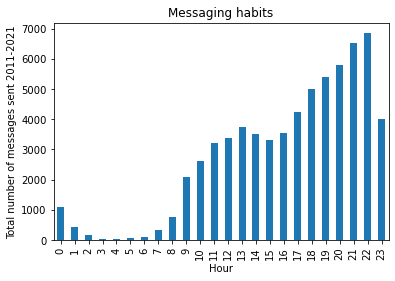

In [2]:
#Messaging habits, at what time of the day I've been sending messages most often

year_min = df['Year'].min()
year_max = df['Year'].max()
y_label = f'Total number of messages sent {year_min}-{year_max}'
df[df['Sent_received'] == 'sent'].groupby('Hour')['Message'].count().plot(kind='bar',title='Messaging habits')
plt.ylabel(y_label)

In [5]:
#Share of top 10 conversation, displayed as a percentage of total number of messages,
#using anonymized data
import names
import random

#generating random names to anonymize data
random_names = {i: names.get_full_name() for i in df['Conversation'].unique()}

#creating new df that will contain anonymized data
df_ano = df.copy()

#replacing real names with randomly generated names
for key,value in random_names.items():
    df_ano.loc[(df_ano['Conversation'] == key) & (df_ano['Conversation_type'] == 'Regular'), 
               ['Conversation','Sender']] = value

#grouping data and keeping only top 10 conversations    
top_10 = df_ano.groupby('Conversation')['Message'].count().nlargest(10)
#calculating % share of total
conv_share =  ((top_10 / len(df) * 100).reset_index()
                .rename(columns={'Message':'% of all messages'})
              )

share_total = conv_share['% of all messages'].sum()
#generating new shares
new_share = {}
for i in conv_share['% of all messages']:
    #random number between 0 and remaining total share
    new_share[i] = random.uniform(0,share_total-sum(new_share.values()))

#getting final df
conv_share = (conv_share.replace({'% of all messages': new_share}).round({'% of all messages': 2})
             .sort_values(by='% of all messages',ascending=False)
             )

#conv_share = conv_share.apply(random_share)
conv_share.head(10)

,Conversation,% of all messages
0,Kenneth Dixon,60.05
2,Patsy Nicholas,6.46
3,Michelle Chappell,5.74
4,Teresa Jenkins,3.30
1,Hazel Webb,3.00
8,Sylvester Garcia,1.31
5,Alice Prewitt,0.96
6,Billy Rowton,0.47
9,Mary Oconnell,0.26
7,Lucinda Mancha,0.24


In [6]:
#Sent to received messages ratio among top 10 conversations

#transforming data
df_sent_rec = (df_ano[df_ano['Conversation'].isin(top_10.index)]
               .groupby(['Conversation','Sent_received'])['Message']
               .count()
               .reset_index()
               .pivot_table(values='Message', index='Conversation',
                   columns='Sent_received')
               .reset_index()
               .set_index('Conversation')
              )

#getting percentages
df_sent_rec = df_sent_rec.div(df_sent_rec.sum(axis=1),axis=0).reset_index().round(2)
df_sent_rec 

Sent_received,Conversation,received,sent
0,Alice Prewitt,0.54,0.46
1,Billy Rowton,0.50,0.50
2,Hazel Webb,0.51,0.49
3,Kenneth Dixon,0.75,0.25
4,Lucinda Mancha,0.53,0.47
5,Mary Oconnell,0.46,0.54
6,Michelle Chappell,0.43,0.57
7,Patsy Nicholas,0.48,0.52
8,Sylvester Garcia,0.56,0.44
9,Teresa Jenkins,0.50,0.50


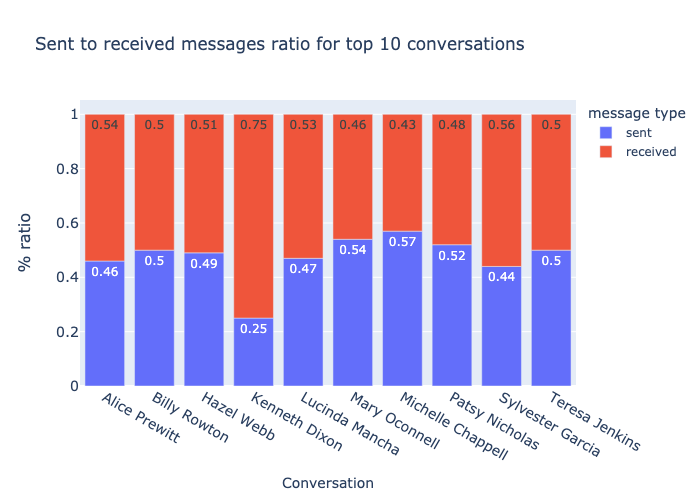

In [7]:
#Visualizing aforementioned sent to received ratio using plotly
import plotly.express as px

sent_rec_fig = px.bar(df_sent_rec, x='Conversation', y=['sent', 'received'],
        title='Sent to received messages ratio for top 10 conversations')
for i, t in enumerate([df_sent_rec['sent'],df_sent_rec['received']]):
    sent_rec_fig.data[i].text = t
    sent_rec_fig.data[i].textposition = 'inside'

sent_rec_fig.update_layout(
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='% ratio',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        title='message type'
    )
)    
    
sent_rec_fig.show('png')

### SQL examples

In [16]:
#Finding percentage of friends with whom i had a conversation with
conn = sqlite3.connect(db_name)
c = conn.cursor()

print(c.execute('''SELECT (CAST(COUNT(*) AS DOUBLE)/CAST((SELECT COUNT(*) FROM FRIENDS) AS DOUBLE)) * 100
                    FROM Friends 
                    WHERE Name IN (Select Conversation from Messages)
                    ''').fetchall())

[(42.30769230769231,)]


In [17]:
#Most popular first names among friends
pprint.pprint(c.execute('''SELECT
                --extracting first name
                SUBSTRING(Name, 1, INSTR(Name, ' ') - 1) AS First_Name
                , COUNT(*)
                FROM Friends F
                GROUP BY First_Name
                ORDER BY COUNT(*) DESC
                LIMIT 10
                ''').fetchall())

conn.close()

[('Paulina', 13),
 ('Mateusz', 10),
 ('Marcin', 10),
 ('Kamil', 9),
 ('Katarzyna', 8),
 ('Paweł', 7),
 ('Michał', 7),
 ('Łukasz', 6),
 ('Piotr', 6),
 ('Karolina', 6)]


### Word Cloud
Generating word cloud with most used words based on messages content.

In [27]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [28]:
text = " ".join(review for review in df['Message'])
print(f"Total number of words found: {len(text)}")

Total number of words found: 5643073


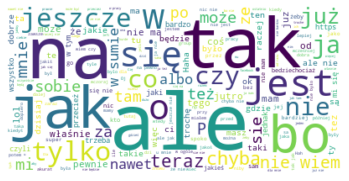

In [29]:
#It's recommended to define stopwords in order to exclude certain, unwanted words from appearing on the picture,
#otherwise result won't be very meaningful
stopwords = set(STOPWORDS)
stopwords.update(["words", "to","exclude"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
#plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()